<a href="https://colab.research.google.com/github/krooner/data-analysis-projects/blob/main/03_classification_cv_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차검증과 랜덤 포레스트를 활용한 와인 품질 분류하기
---

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 2. Download dataset

In [3]:
!wget 'https://bit.ly/3i4n1QB'

import zipfile
with zipfile.ZipFile('3i4n1QB', 'r') as existing_zip:
    existing_zip.extractall('data')

--2022-05-22 05:37:53--  https://bit.ly/3i4n1QB
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw [following]
--2022-05-22 05:37:53--  https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw
Resolving drive.google.com (drive.google.com)... 142.250.145.138, 142.250.145.101, 142.250.145.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.145.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4ihucsbcg6et9arbqq7jnq3nctms23ct/1653197850000/17946651057176172524/*/1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw?e=download [following]
--2022-05-22 05:37:54--  https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0r

## 3. Load file

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## 4. EDA

### `train`
피쳐 종류는 다음과 같다.


||index|quality|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|totla sulfur dioxide|density|pH|sulphates|alcohol|type|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---| 
||구분자|품질|산도|휘발성산|시트르산|잔당|염화물|독립 이산화황|총 이산화황|밀도|수소이온농도|황산염|도수|종류|

`quality`는 종속 변수로, 3부터 9까지의 정수

`type`을 제외한 컬럼이 모두 수치형 데이터이다. 
- **수치형 데이터 간의 상관관계** 분석을 통해 필요없는 피쳐는 제외한다.

`type`과 같은 카테고리 변수는 One-hot Vector 변환

In [5]:
print(train.info())
print()
# print(train.isnull().sum())
# print()
print(train.describe())
print()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 601.4+ KB
None

      

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


### 시각화
`quality`에 대한 히스토그램

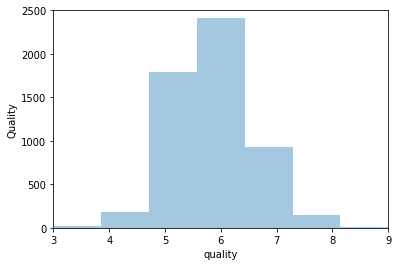

In [8]:
sns.distplot(train['quality'], kde = False, bins = 7)
plt.axis([3, 9, 0, 2500])
plt.ylabel("Quality")
plt.show()

### 전체 수치형 변수 간의 상관관계 시각화

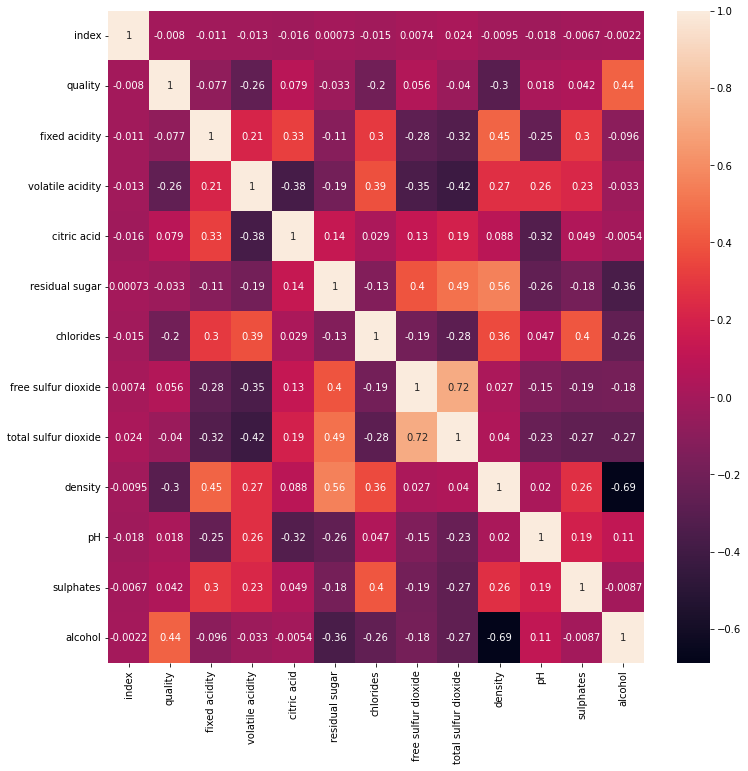

In [9]:
plt.figure(figsize = (12, 12))
sns.heatmap(train.corr(), annot = True)

### `test`
피쳐 종류는 `count`를 제외하고 동일하며, 역시 결측치가 존재한다.

In [10]:
print(test.info())
print()
# print(test.isnull().sum())
# print()
print(test.describe())
print()
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 1000 non-null   int64  
 1   fixed acidity         1000 non-null   float64
 2   volatile acidity      1000 non-null   float64
 3   citric acid           1000 non-null   float64
 4   residual sugar        1000 non-null   float64
 5   chlorides             1000 non-null   float64
 6   free sulfur dioxide   1000 non-null   float64
 7   total sulfur dioxide  1000 non-null   float64
 8   density               1000 non-null   float64
 9   pH                    1000 non-null   float64
 10  sulphates             1000 non-null   float64
 11  alcohol               1000 non-null   float64
 12  type                  1000 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 101.7+ KB
None

             index  fixed acidity  volatile acidity  citri

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white
1,1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red
2,2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white
3,3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white
4,4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white


## 5. 전처리
이상치를 어떻게 처리할 것인가? 예 - `fixed acidity`

#### Boxplot에서 `[minimum, maximum]` 값 이외에는 제거하기

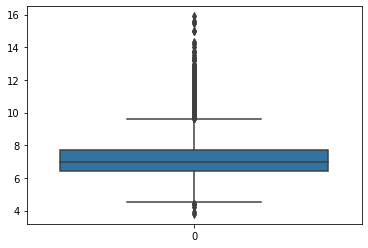

(5497, 14)
(5203, 14)
Number of outliers: 294


In [14]:
sns.boxplot(data = train['fixed acidity'])
plt.show()

quantile_25 = np.quantile(train['fixed acidity'], .25)
quantile_75 = np.quantile(train['fixed acidity'], .75)
IQR = quantile_75 - quantile_25

minimum = quantile_25 - 1.5 * IQR
maximum = quantile_75 + 1.5 * IQR

train_boxplot = train[(minimum < train['fixed acidity']) & (train['fixed acidity'] < maximum)]

print(train.shape)
print(train_boxplot.shape)
print(f"Number of outliers: {train.shape[0] - train_boxplot.shape[0]}")

#### 데이터 정규화 (Normalization) - `MinMaxScaler`
1. `MinMaxScaler`를 선언한다.
2. 정규화 하려는 컬럼 값을 학습 데이터에서 추출하여 Scaler를 구성한다.
3. `train, test` 데이터에 Scaler를 적용하여 정규화된 값을 얻는다.

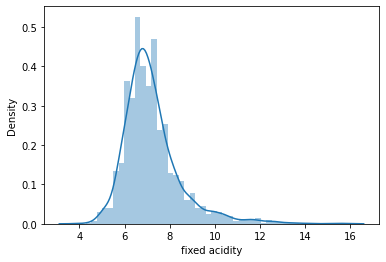

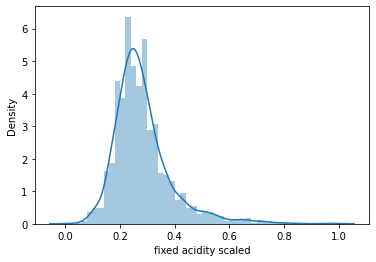

In [16]:
sns.distplot(train['fixed acidity'])
plt.show()

scaler = MinMaxScaler()
scaler.fit(train[['fixed acidity']])

train['fixed acidity scaled'] = scaler.transform(train[['fixed acidity']])
test['fixed acidity scaled'] = scaler.transform(test[['fixed acidity']])

sns.distplot(train['fixed acidity scaled'])
plt.show()

#### 카테고리 변수를 처리하기 위한 One-hot encoding
1. `OneHotEncoder`를 선언한다.
2. 인코딩하려는 컬럼 값을 학습 데이터에서 추출하여 Encoder를 구성한다.
3. `train, test`에 있는 해당 컬럼 데이터에 Encoder를 적용하여 인코딩된 값을 얻는다.

---

인코딩된 값을 `np.array`로 바꾼 다음 `pd.DataFrame`으로 만든다.

`train, test`에 인코딩된 DataFrame을 병합한다.


In [21]:
encoder = OneHotEncoder()
encoder.fit(train[['type']])

onehot_train = encoder.transform(train[['type']]).toarray()
onehot_test = encoder.transform(test[['type']]).toarray()

onehot_train = pd.DataFrame(onehot_train)
onehot_train.columns = encoder.get_feature_names()

onehot_test = pd.DataFrame(onehot_test)
onehot_test.columns = encoder.get_feature_names()

train_encoded = pd.concat([train, onehot_train], axis = 1)
train_encoded.drop(columns = ['type'], inplace = True)

test_encoded = pd.concat([test, onehot_test], axis = 1)
test_encoded.drop(columns = ['type'], inplace = True)

## 6. 모델링

1. `분류`를 위해 `DecisionTreeClassifier`를 선언한다.
2. 모델을 학습시킨다.

In [29]:
model = RandomForestClassifier(random_state = 42)

X_train = train_encoded.drop(columns = ['quality', 'index'])
Y_train = train_encoded['quality']

X_test = test_encoded.drop(columns = ['index'])

model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

## 7. 평가
`K-Fold Cross Validation`을 적용한다.
1. `train` 데이터셋을 `K-Fold`로 분할하여 `train_data, valid_data`를 구성한다.
2. 매 fold마다 모델을 초기화하고 `train_data`로 학습시킨다.
3. 학습된 모델을 `valid_data`로 평가하여 점수를 계산한다.
4. `K`번 반복하여 얻은 점수들을 평균낸다.

In [31]:
k = 5
kf = KFold(n_splits = k, shuffle = True, random_state = 42)

valid_scores = []
test_predictions = []

for i, (train_idx, valid_idx) in enumerate(kf.split(X_train, Y_train)) :
  X_fold_train = X_train.iloc[train_idx]
  Y_fold_train = Y_train.iloc[train_idx]

  X_fold_val = X_train.iloc[valid_idx]
  Y_fold_val = Y_train.iloc[valid_idx]

  model.fit(X_fold_train, Y_fold_train)

  valid_prediction = model.predict(X_fold_val)
  score = accuracy_score(Y_fold_val, valid_prediction)
  
  valid_scores.append(score)
  print(f"[{i+1}/{k}] Validation score: {score}")

  test_prediction = model.predict(X_test)
  test_predictions.append(test_prediction)

print(f"Average score: {np.mean(valid_scores)}")

[1/5] Validation score: 0.6781818181818182
[2/5] Validation score: 0.6736363636363636
[3/5] Validation score: 0.6642402183803457
[4/5] Validation score: 0.6860782529572339
[5/5] Validation score: 0.6660600545950864
Average score: 0.6736393415501697


## 7. 결과 저장

In [34]:
test_predictions = pd.DataFrame(test_predictions)
test_prediction = test_predictions.mode()
test_prediction = test_predictions.values[0]
test_prediction

sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['quality'] = test_prediction
sample_submission.to_csv('submission_KFOLD.csv', index=False)

## 8. 하이퍼파라미터 튜닝
Bayesian Optimization

In [48]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization

rf_parameter_bounds = {
    'max_depth': (1, 14),
    'n_estimators': (50, 500)
}

def bayes_function(max_depth, n_estimators):
  param = {
      'max_depth': int(round(max_depth)),
      'n_estimators': int(round(n_estimators))
  }
  
  model = RandomForestClassifier(**param)

  X_train_bo, X_valid_bo, Y_train_bo, Y_valid_bo = train_test_split(X_train, Y_train, test_size = .2)

  model.fit(X_train_bo, Y_train_bo)
  score = accuracy_score(Y_valid_bo, model.predict(X_valid_bo))

  return score

In [49]:
bayes_rf = BayesianOptimization(
    f = bayes_function, 
    pbounds = rf_parameter_bounds,
    random_state = 42)

bayes_rf.maximize(init_points = 5, n_iter = 5)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.5845   |  5.869    |  477.8    |
|  2        |  0.65     |  10.52    |  319.4    |
|  3        |  0.5245   |  3.028    |  120.2    |
|  4        |  0.5336   |  1.755    |  439.8    |
|  5        |  0.6127   |  8.814    |  368.6    |
|  6        |  0.4536   |  1.464    |  281.1    |
|  7        |  0.6482   |  9.864    |  320.3    |
|  8        |  0.66     |  14.0     |  343.8    |
|  9        |  0.6427   |  14.0     |  50.0     |
|  10       |  0.4709   |  1.0      |  71.61    |


## 결과 저장

In [50]:
max_params = bayes_rf.max['params']
max_params['max_depth'] = int(max_params['max_depth'])
max_params['n_estimators'] = int(max_params['n_estimators'])
max_params

{'max_depth': 14, 'n_estimators': 343}

In [51]:
model_bayes_tuned = RandomForestClassifier(**max_params)
model_bayes_tuned.fit(X_train, Y_train)

pred = model_bayes_tuned.predict(X_test)

df = pd.read_csv("data/sample_submission.csv")
df['quality'] = pred
df.to_csv("submission_bayes.csv", index = False)